# Prédiction de séries temporelles avec les réseaux neuronaux récurrents

Dans ce TP, nous allons explorer les réseaux neuronaux récurrents sous l'angle de la prédiction de séries temporelles.
Le cas de figure que nous allons explorer est un peu différent des séries temporelles que nous avons vues précédemment dans le cours: au lieu de prédire des valeurs $y$ à partir de valeurs $x$, nous allons prédire $y_t$ à partir d'une ou plusieurs valeurs précédentes $y_{t-k}$.

## Génération des données

Comme premier exemple, nous utiliserons un ensemble de données simulées très simple: une série temporelle non-bruitée, parfaitement périodique et avec un échantillonnage uniforme dans le temps.

In [1]:
from typing import Tuple

import torch
from torch import nn, Tensor

P = 1.0
N_cycles = 12.0
N_pts = 1000
# valeurs de temps, utilisées pour générer y mais pas dans l'analyse
t = torch.linspace(0, N_cycles * P, N_pts)
y = torch.sin(2 * torch.pi * t / P)

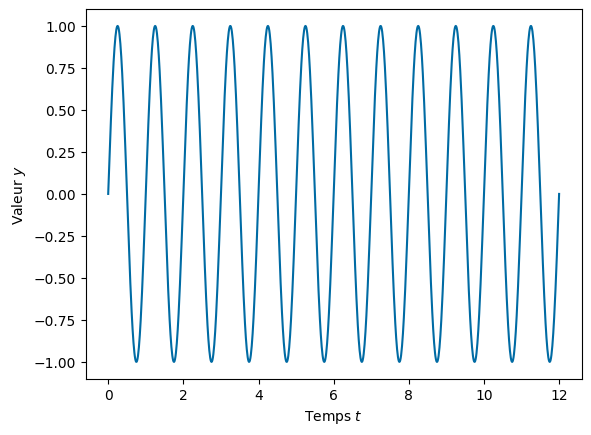

In [2]:
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")

plt.plot(t, y)
plt.xlabel("Temps $t$")
plt.ylabel("Valeur $y$")
plt.show()

## Module RNN avec PyTorch

Nous avons vu les équations d'un RNN en classe. Or, PyTorch implémente déjà un RNN avec [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). La documentation donne les équations utilisées et une idée conceptuelle de l'implémentation.

Nous utiliserons `nn.RNN` dans un réseau sous peu, mais d'abord, créons un modèle composé uniquement d'un bloc RNN, pour en explorer les caractéristiques.

In [3]:
myrnn = nn.RNN(input_size=1, hidden_size=10, num_layers=1, nonlinearity="tanh", batch_first=True)
myrnn

RNN(1, 10, batch_first=True)

Quelques notes sur les arguments ci-dessus:

- `input_size` est la dimension d'entrée. Par exemple, chaque point dans notre séquence pourrait être un vecteur en N-dimension. Dans le cas présent, chaque point de la séquence $y$ est un seul chiffre donc `input_size=1`. **Cet argument est requis**
- `hidden_size` est la dimension de chaque élément $h_t$ la couche cachée. On choisit une valeur selon la capacité désirée pour notre modèle. **Cet argument est requis**
- `num_layers=1` est le nombre de couches dans notre RNN. On pourrait avoir plusieurs couches RNN créées avec le même bloc (1 par défaut).
- `nonlinearity="tanh"` est la fonction d'activation à utiliser dans notre bloc RNN
- `batch_first=True` (`False` par défault!): Si la dimension des sous-ensembles devrait être avant la dimension de séquence. Voir le prochain paragraphe.

Une fois ce bloc créé, on peut lui donner une séquence de points. Tel que mentionné dans la documentation, les entrées accepté par notre RNN sont:

- `input`: Un tenseur de format `(L, input_size)` pour une seule séquence de longueur $L$ ou `(batch_size, L, input_size)` pour un sous ensemble de plusieurs séquence. Ici, `batch_size` est en premier car nous avons utilisé `batch_first=True`.
- `hx` (optional): Un tenseur contenant l'état initial $h_0$ pour la couche cachée. Initialisé à 0 par défaut.

In [4]:
try:
    myrnn(y)
except Exception as e:
    print(f"Erreur: '{e}'")

out, hn = myrnn(y.unsqueeze(1))

Erreur: 'RNN: Expected input to be 2D or 3D, got 1D tensor instead'


Comme notre tenseur $y$ est 1D, il faut ajouter la dimension `input_size` de 1, à la position 1 (2e axe) avec `y.unsqueeze(1)`. Examinons les sorties:

In [5]:
print("out shape", out.shape)
print("hn shape", hn.shape)

out shape torch.Size([1000, 10])
hn shape torch.Size([1, 10])


On peut voir que le RNN retourne deux éléments:

- `out`: Un tenseur de dimension `(L, hidden_size)` représentant la sortie ($h_t$ de la dernière couche pour tous les temps $t$)
- `hn`: Un tenseur de dimension `(num_layers, hidden_size)` représentant le dernier étant caché du réseau (qui serait complètement à droite danns les graphiques vus en classe).

Notez que le modèle retourne une sortie pour chaque pas de temps en entrée.
Dans notre cas, seul la dernière sortie nous intéresse pour la prédiction.
On pourra donc aller indexer `out[..., -1, :]` au besoin.
On aurait aussi peut également faire cette modification directement dans le réseau, comme dans la cellule ci-dessous.

## Modèle complet RNN avec PyTorch

Nous allons maintenant utiliser le bloc RNN décrit ci-dessous dans un réseau un tout petit peu plus complexe afin de faire une prédiction de série temporelle. Notre modèle aura les composantes suivantes:

- Un bloc RNN. N'oubliez pas `batch_first=True`!
- Un bloc linéaire transformant la dimension cachéé du RNN vers la dimension de sortie désirée

**Exercice: Complétez les fonctions `__init__()` et `forward()` du modèle ci-dessous. Créez ensuite un modèle RNN avec 32 dimensions pour h.**

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, rnn_type: str = "rnn"):
        super().__init__()
        if rnn_type.lower() == "rnn":
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif rnn_type.lower() == "lstm":
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif rnn_type.lower() == "gru":
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, x, return_seq: bool = False):
        out, hn = self.rnn(x)
        out = self.linear(out)
        if not return_seq:
            # L'avant dernier axe est celui de la séquence L. On veut seulement le dernier point
            out = out[..., -1:, :]
        return out

model = RNNModel(1, 32, 1)

In [7]:
model

RNNModel(
  (rnn): RNN(1, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:
out = model(y.unsqueeze(1))

In [9]:
out.shape

torch.Size([1, 1])

In [10]:
model(y.unsqueeze(1), return_seq=True).shape

torch.Size([1000, 1])

## Préparation des données

La série temporelle `y` n'a pas un format idéal. Afin d'entraîner notre modèle, il faudrait:

- Ajouter une dimension `input_dim` pour ne pas avoir à utiliser `.unsqueeze(1)` sans arrêt.
- Séparer les données en un ensemble d'entraînement et un ensemble de test.
- Structurer les données pour apprendre une prédiction future

In [11]:
Y = y.unsqueeze(1)

### Données d'entraînement et de test

Commençons d'abord par séparer les données d'entraînement et de test.
Comme il s'agit d'une tâche de prédiction future (_forecasting_), nous allons séparer les données dans le temps.
Le premier 80% constituera l'ensemble d'entraînement, et le reste l'ensemble de test.

**Exercice: Séparez `Y` en deux sous-ensembles: un d'entraînement et un de test. Vous pouvez également séparer `t` de la même façon. Ce sera utile pour l'affichage des données.** Nous utiliserons une fonction pour pouvoir réappliquer cette logique au besoin.

In [12]:
train_fraction = 0.8

N_tot = len(Y)
N_train = int(N_tot * train_fraction)
N_test = N_tot - N_train

Y_train = Y[:N_train]
Y_test = Y[N_train:]
t_train = t[:N_train]
t_test = t[N_train:]

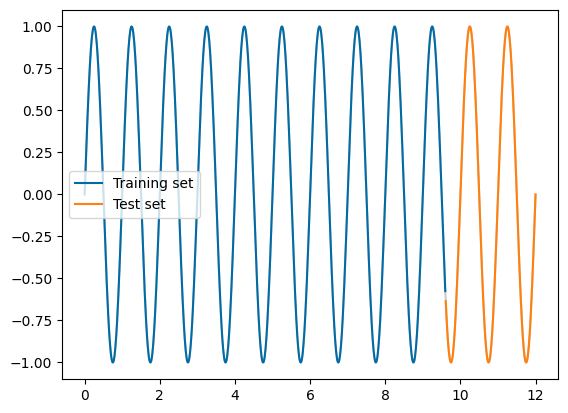

In [13]:
plt.plot(t, Y, "k", alpha=0.2)
plt.plot(t_train, Y_train, label="Training set")
plt.plot(t_test, Y_test, label="Test set")
plt.legend()
plt.show()

### Structure des données pour l'apprentissage

Comme la tâche qui nous intéresse est une prédiction future, il faut structurer nos données un peu différemment d'à l'habitude. Il faut d'abord réfléchir à ce qui constitue notre entrée (_features_, l'équivalent de l'image dans un problème de classification) et notre sortie ou _cible_ (l'équivalent de la catégorie dans une classification).

Le cas de prédiction le plus simple à considérer est le suivant: nous utiliserons une _fenêtre_ de $N$ points passés pour prédire le prochain point. Pour entraîner un modèle à résoudre ce problème, il nous faut restructurer les données de test et d'entraînement. Utilisons une fenêtre de 40 points, par exemple. On commence par prendre les 40 premiers points de notre ensemble d'entraînement comme entrée (_feature_). La cible correspondante est le point suivant, donc le point 41. Ceci constitue notre premier exemple d'entraînement. Le 2e exemple aura comme entrée les poitns 2 à 41 et comme sortie le point 42, et ainsi de suite.

**Note: Le choix de 40 points est arbitraire ici. D'autres valeurs donneraient des caractéristiques différentes au modèle. En général plus la fenêtre dont on dispose est longue, plus on peut s'attendre à ce que le pouvoir prédictif soit robuste.**

On peut mettre la logique décrite ci-dessus dans une fonction

In [14]:
def get_windowed_data(data: Tensor, window_size: int, target_size: int = 1) -> Tuple[Tensor, Tensor]:
    N_samples = len(data) - window_size
    assert N_samples > 0, "Negative numer of samples: less points than window size"
    features, targets = [], []
    for i in range(N_samples):
        features.append(data[i:i+window_size])
        targets.append(data[i+window_size:i+window_size+target_size])
    return torch.stack(features), torch.stack(targets)

window_size = 40
train_features, train_targets = get_windowed_data(Y_train, window_size)
test_features, test_targets = get_windowed_data(Y_test, window_size)

In [15]:
print("Format des features d'entraînement:", train_features.shape)
print("Format des targets d'entraînement:", train_targets.shape)
print("Format des features de test:", test_features.shape)
print("Format des targets de test:", test_targets.shape)

Format des features d'entraînement: torch.Size([760, 40, 1])
Format des targets d'entraînement: torch.Size([760, 1, 1])
Format des features de test: torch.Size([160, 40, 1])
Format des targets de test: torch.Size([160, 1, 1])


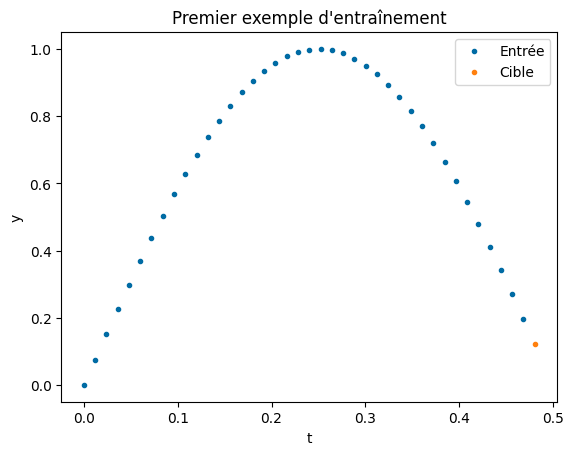

In [16]:
plt.plot(t_train[:window_size], train_features[0], ".", label="Entrée")
plt.plot(t_train[window_size], train_targets[0], ".", label="Cible")
plt.title("Premier exemple d'entraînement")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [17]:
out = model(train_features)
print(out.shape)

torch.Size([760, 1, 1])


**Exercice: Affichez la prédiction initiale du modèle pour un seul exemple d'entraînement.**

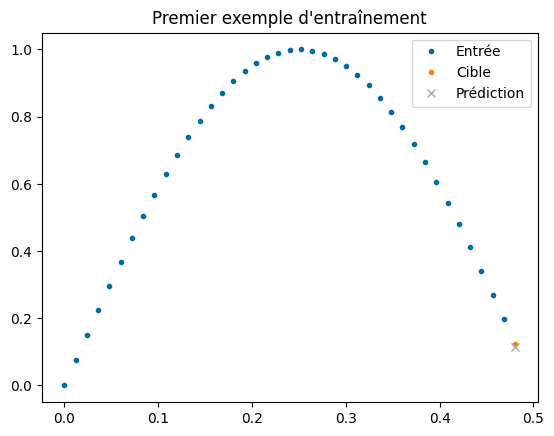

In [18]:
plt.plot(t_train[:window_size], train_features[0], ".", label="Entrée")
plt.plot(t_train[window_size], train_targets[0], ".", label="Cible")
plt.plot(t_train[window_size], model(train_features[0]).detach()[-1], "x", label="Prédiction")
plt.title("Premier exemple d'entraînement")
plt.legend()
plt.show()

En exploitant une dimension de sous-ensemble, on peut également générer la prédiction du modèle pour toutes les fenêtre en même temps.

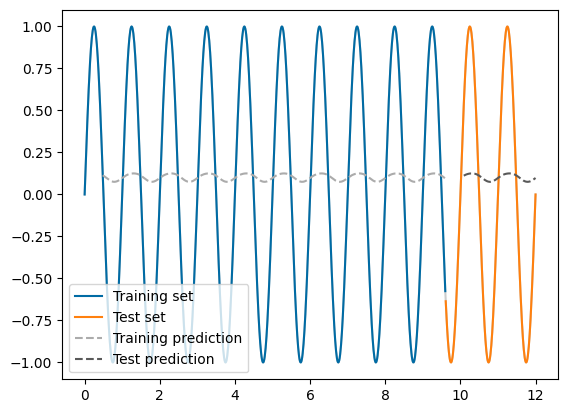

In [19]:
train_pred = model(train_features)[:, -1, :]
test_pred = model(test_features)[:, -1, :]

plt.plot(t, Y, "k", alpha=0.2)
plt.plot(t_train, Y_train, label="Training set")
plt.plot(t_test, Y_test, label="Test set")
plt.plot(t_train[window_size:], train_pred.detach(), "--", label="Training prediction")
plt.plot(t_test[window_size:], test_pred.detach(), "--", label="Test prediction")
plt.legend()
plt.show()

Remarquez que comme nous utilisons la fenêtre pour générer nos prédiction, les $N$ premiers points n'ont pas de prédiction, tant dans les données d'entraînement que dans les données test.

### Dataset PyTorch

Les données ci-dessus pourraient être utilisées directement pour entraîner le réseau, mais nous n'avons qu'un seul ensemble.
Il serait préférable de partitioner les données en sous-ensembles.

Bonne nouvelle: on peut créer un `Dataset` PyTorch à partir de n'importe quelle paire de tenseurs! Il suffit d'utiliser `TensorDataset`.

In [20]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(train_features, train_targets)
test_set = TensorDataset(test_features, test_targets)

In [21]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

## Entraînement du modèle

**Exercice: Définissez une boucle d'entraînement pour le modèle.**

- Définissez un modèle (pour que chaque exécution de la cellule réinitialise les poids)
- Utilisez une fonction objectif MSE
- Utilisez un optimiseur Adam
- Emmagasinez la valeur de la fonction objectif pour les données test et d'entraînement à chaque époque.
- Suggestion: afin de voir le modèle s'améliorer en temps réel, calculez la prédiction sur toutes les données d'entraînement et de test à chaque époque (en utilisant `train_features` et `test_features` directement) et affichez la sur un graphique similaire à celui montré ci-dessus pour les paramètres initiaux.

In [22]:
model = RNNModel(1, 32, 1, rnn_type="RNN")
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

N_epochs = 10
train_losses = []
PLOT_TRAIN = False
PLOT_FREQ = 3
PRINT_FREQ = 1
test_losses = []
for epoch in range(N_epochs):
    model.train()  # Active certaines options (e.g. dropout)
    train_loss = 0.0
    for batch, (feature, target) in enumerate(train_loader):
        train_pred = model(feature)[:, -1:, :]
        loss = loss_fn(train_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * feature.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()  # Mets le modèle en mode "prédiction" (sans dropout, etc.)
    with torch.no_grad():
        test_loss = 0.0
        for batch, (feature, target) in enumerate(test_loader):
            test_pred = model(feature)[:, -1:, :]
            loss = loss_fn(test_pred, target)

            test_loss += loss.item() * feature.size(0)
        test_losses.append(test_loss / len(test_loader.dataset))

    if epoch % PRINT_FREQ == 0:
        print(f"Epoch {epoch}: train loss = {train_losses[-1]}, test loss = {test_losses[-1]}")
    if PLOT_TRAIN and epoch % PLOT_FREQ == 0:
        if epoch != 0:
            plt.plot(train_losses, label="Train loss")
            plt.plot(test_losses, label="Test loss")
            plt.show()

        train_pred = model(train_features)[:, -1, :]
        test_pred = model(test_features)[:, -1, :]

        plt.plot(t, Y, "k", alpha=0.2)
        plt.plot(t_train, Y_train, label="Training set")
        plt.plot(t_test, Y_test, label="Test set")
        plt.plot(t_train[window_size:], train_pred.detach(), "--", label="Training prediction")
        plt.plot(t_test[window_size:], test_pred.detach(), "--", label="Test prediction")
        plt.legend()
        plt.show()

Epoch 0: train loss = 0.16093439665181855, test loss = 0.011073872621636838
Epoch 1: train loss = 0.0038804155399128305, test loss = 0.0006347674043354345
Epoch 2: train loss = 0.0005153346698391129, test loss = 0.00028265533455851255
Epoch 3: train loss = 0.00026930076647228195, test loss = 0.0003058954266634828
Epoch 4: train loss = 0.00019669407500163958, test loss = 0.00021050128862043493
Epoch 5: train loss = 0.00014259070906662505, test loss = 9.118846037381445e-05
Epoch 6: train loss = 9.969283315800375e-05, test loss = 0.00012342578747848165
Epoch 7: train loss = 7.687565206843398e-05, test loss = 7.317733752643107e-05
Epoch 8: train loss = 6.651955557476628e-05, test loss = 9.2138213403814e-05
Epoch 9: train loss = 5.4994136737724675e-05, test loss = 4.1896201423696766e-05


**Exercice: Affichez l'évolution de la fonction objectif**

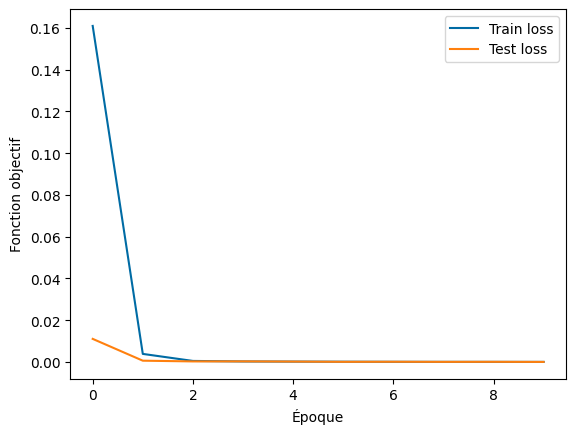

In [23]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Époque")
plt.ylabel("Fonction objectif")
plt.legend()
plt.show()

## Prédiction finale

### Prédiction d'un point

**Exercice: Affichez la prédiction finale pour les données d'entraînement et de test**

Avec la configuration initiale, la prédiction devrait être presque parfaite.

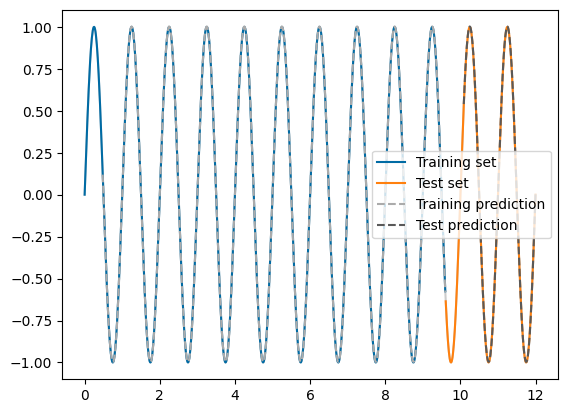

In [24]:
train_pred = model(train_features)[:, -1, :]
test_pred = model(test_features)[:, -1, :]

plt.plot(t, Y, "k", alpha=0.2)
plt.plot(t_train, Y_train, label="Training set")
plt.plot(t_test, Y_test, label="Test set")
plt.plot(t_train[window_size:], train_pred.detach(), "--", label="Training prediction")
plt.plot(t_test[window_size:], test_pred.detach(), "--", label="Test prediction")
plt.legend()
plt.show()

### Prédiction auto-régressive

Une autre façon d'utiliser un modèle comme celui-ci est de manière auto-régressive: on utilise la dernière prédiction du modèle pour faire plus de pas dans le futur.

Voici un petit exemple. Comme on peut voir, le résultat n'est pas excellent. Ce n'est pas trop surprenant: nous n'avons pas explicitement entraîné notre modèle pour accomplir cette tâche. Par contre, certains modèles (ex.: LSTM) performent mieux que d'autres. La taille de la fenêtre utilisée dans l'entraînement aura également un impact.

In [25]:
new_Y = torch.cat([Y_train, torch.empty(200, 1)])
with torch.no_grad():
    for i in range(N_train, len(new_Y)):
        new_pred = model(new_Y[i-window_size:i])
        new_Y[i] = new_pred[..., -1:, :]

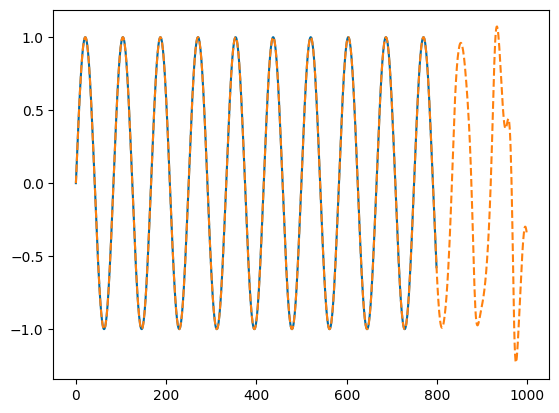

In [26]:
plt.plot(y[:N_train])
plt.plot(new_Y, "--")
plt.show()

## Exercice: Exploration des hyperparamètres

1. Testez l'impact de la fenêtre d'entraînement. Sur la qualité des prédictions Vous pouvez tester une fenêtre de 1, de 10, de 80, etc.
2. Testez l'impact de remplacer le RNN par une autre architecture vue en classe, telle que le LSTM ou le GRU. Quel est l'impact sur l'entraînement? Et sur la prédiction?
3. Variez le nombre de dimensions pour la couche cachée du RNN. Quel est l'impact sur la prédiction?

Ce ne sont que quelques suggetions. N'hésitez pas à explorer d'autres modifications!

## Exercice: Données de CO2 Mauna Loa

Un exemple souvent utilisé pour les extrapolations est celui de l'évolution du CO2 mesuré sur le Mauna Loa.
La libraire `statsmodels` donne accès à ces données.

**Exercice: Utilisez le RNN ci-dessus pour prédire les données du Mauna Loa. Comment se compare la qualité des préductions avec l'exemple simple du sinusoide?**

Vous pouvez simplement copier la cellule ci-dessous en haut du notebook et commenter la cellule où le sinusoide est généré: tout devrait fonctionner!

Vous devrez fort probablement changer le nombre d'époques dans l'entraînement.

Aussi, une simple transformation des données aide à accélérer l'entraînement. Pouvez-vous identifier laquelle?

In [27]:
from statsmodels.datasets import co2

y = torch.from_numpy(co2.load_pandas().data.values.ravel().astype("float32"))
y = y[~torch.isnan(y)]
t = torch.arange(len(y))

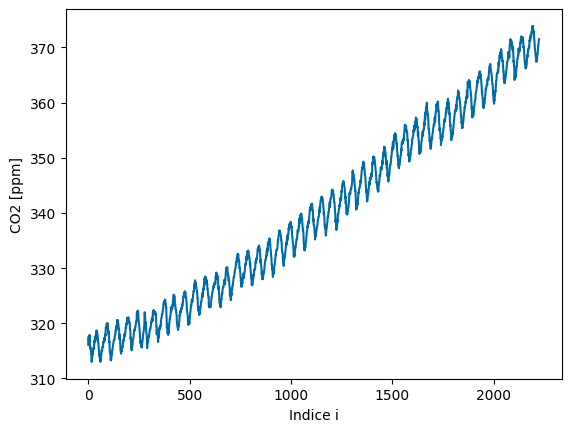

In [28]:
plt.plot(t, y)
plt.ylabel("CO2 [ppm]")
plt.xlabel("Indice i")
plt.show()

In [29]:
NORM = True
if NORM:
    y = (y - y.mean()) / y.std()

In [30]:
Y = y.unsqueeze(1)

In [31]:
N_tot = len(Y)
N_train = int(N_tot * train_fraction)
N_test = N_tot - N_train

Y_train = Y[:N_train]
Y_test = Y[N_train:]
t_train = t[:N_train]
t_test = t[N_train:]

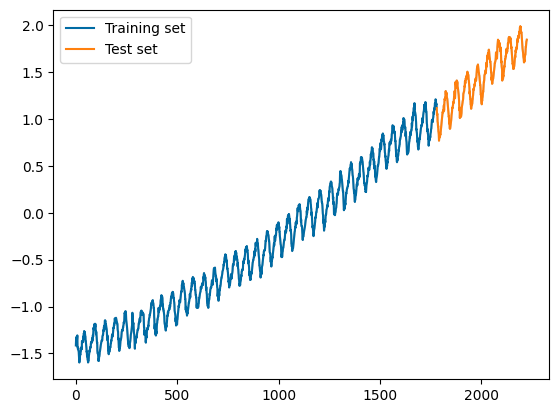

In [32]:
plt.plot(t, Y, "k", alpha=0.2)
plt.plot(t_train, Y_train, label="Training set")
plt.plot(t_test, Y_test, label="Test set")
plt.legend()
plt.show()

In [33]:
window_size = 40
train_features, train_targets = get_windowed_data(Y_train, window_size)
test_features, test_targets = get_windowed_data(Y_test, window_size)

In [34]:
print("Format des features d'entraînement:", train_features.shape)
print("Format des targets d'entraînement:", train_targets.shape)
print("Format des features de test:", test_features.shape)
print("Format des targets de test:", test_targets.shape)

Format des features d'entraînement: torch.Size([1740, 40, 1])
Format des targets d'entraînement: torch.Size([1740, 1, 1])
Format des features de test: torch.Size([405, 40, 1])
Format des targets de test: torch.Size([405, 1, 1])


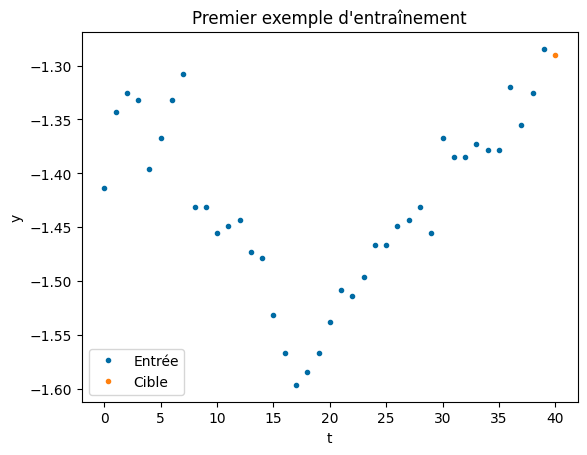

In [35]:
plt.plot(t_train[:window_size], train_features[0], ".", label="Entrée")
plt.plot(t_train[window_size], train_targets[0], ".", label="Cible")
plt.title("Premier exemple d'entraînement")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [36]:
out = model(train_features)
print(out.shape)

torch.Size([1740, 1, 1])


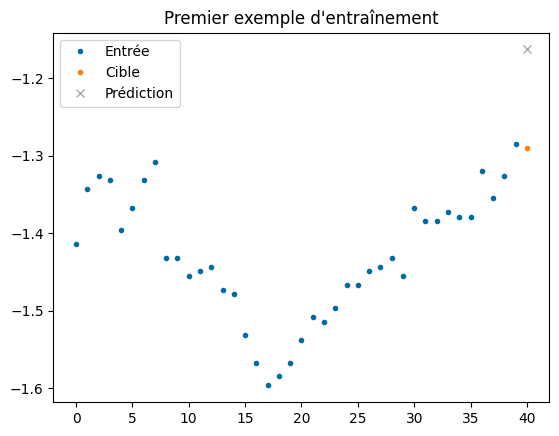

In [37]:
plt.plot(t_train[:window_size], train_features[0], ".", label="Entrée")
plt.plot(t_train[window_size], train_targets[0], ".", label="Cible")
plt.plot(t_train[window_size], model(train_features[0]).detach()[-1], "x", label="Prédiction")
plt.title("Premier exemple d'entraînement")
plt.legend()
plt.show()

En exploitant une dimension de sous-ensemble, on peut également générer la prédiction du modèle pour toutes les fenêtre en même temps.

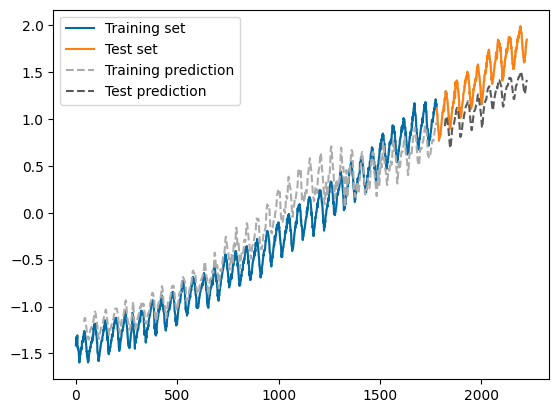

In [38]:
train_pred = model(train_features)[:, -1, :]
test_pred = model(test_features)[:, -1, :]

plt.plot(t, Y, "k", alpha=0.2)
plt.plot(t_train, Y_train, label="Training set")
plt.plot(t_test, Y_test, label="Test set")
plt.plot(t_train[window_size:], train_pred.detach(), "--", label="Training prediction")
plt.plot(t_test[window_size:], test_pred.detach(), "--", label="Test prediction")
plt.legend()
plt.show()

In [39]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(train_features, train_targets)
test_set = TensorDataset(test_features, test_targets)

In [40]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [41]:
model = RNNModel(1, 32, 1, rnn_type="LSTM")
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

N_epochs = 10
train_losses = []
PLOT_TRAIN = False
PLOT_FREQ = 3
PRINT_FREQ = 1
test_losses = []
for epoch in range(N_epochs):
    model.train()  # Active certaines options (e.g. dropout)
    train_loss = 0.0
    for batch, (feature, target) in enumerate(train_loader):
        train_pred = model(feature)[:, -1:, :]
        loss = loss_fn(train_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * feature.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()  # Mets le modèle en mode "prédiction" (sans dropout, etc.)
    with torch.no_grad():
        test_loss = 0.0
        for batch, (feature, target) in enumerate(test_loader):
            test_pred = model(feature)[:, -1:, :]
            loss = loss_fn(test_pred, target)

            test_loss += loss.item() * feature.size(0)
        test_losses.append(test_loss / len(test_loader.dataset))

    if epoch % PRINT_FREQ == 0:
        print(f"Epoch {epoch}: train loss = {train_losses[-1]}, test loss = {test_losses[-1]}")
    if PLOT_TRAIN and epoch % PLOT_FREQ == 0:
        if epoch != 0:
            plt.plot(train_losses, label="Train loss")
            plt.plot(test_losses, label="Test loss")
            plt.show()

        train_pred = model(train_features)[:, -1, :]
        test_pred = model(test_features)[:, -1, :]

        plt.plot(t, Y, "k", alpha=0.2)
        plt.plot(t_train, Y_train, label="Training set")
        plt.plot(t_test, Y_test, label="Test set")
        plt.plot(t_train[window_size:], train_pred.detach(), "--", label="Training prediction")
        plt.plot(t_test[window_size:], test_pred.detach(), "--", label="Test prediction")
        plt.legend()
        plt.show()

Epoch 0: train loss = 0.14843173855888903, test loss = 0.20632975539307535
Epoch 1: train loss = 0.0062529373299812195, test loss = 0.12496876348683864
Epoch 2: train loss = 0.004320483099423006, test loss = 0.05614420044937252
Epoch 3: train loss = 0.0027764343016649777, test loss = 0.02292209307168737
Epoch 4: train loss = 0.002085946022262583, test loss = 0.019279159053608223
Epoch 5: train loss = 0.0016451549245280095, test loss = 0.0094840725492916
Epoch 6: train loss = 0.0014417054820417736, test loss = 0.007218588471274685
Epoch 7: train loss = 0.001296377570024456, test loss = 0.008715183232669477
Epoch 8: train loss = 0.0012448108760906309, test loss = 0.008749944382105712
Epoch 9: train loss = 0.0012100285659115975, test loss = 0.009384191842220816


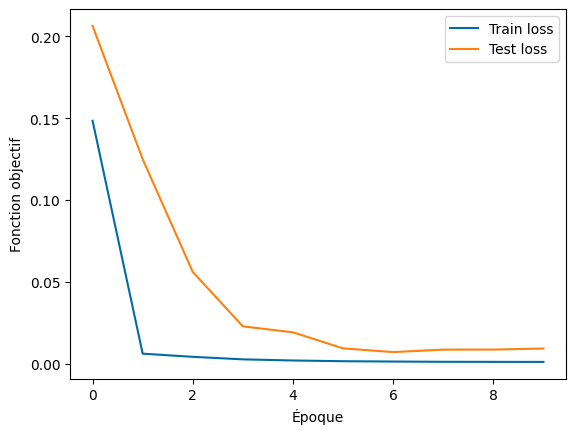

In [42]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Époque")
plt.ylabel("Fonction objectif")
plt.legend()
plt.show()

## Prédiction finale

### Prédiction d'un point

**Exercice: Affichez la prédiction finale pour les données d'entraînement et de test**

Avec la configuration initiale, la prédiction devrait être presque parfaite.

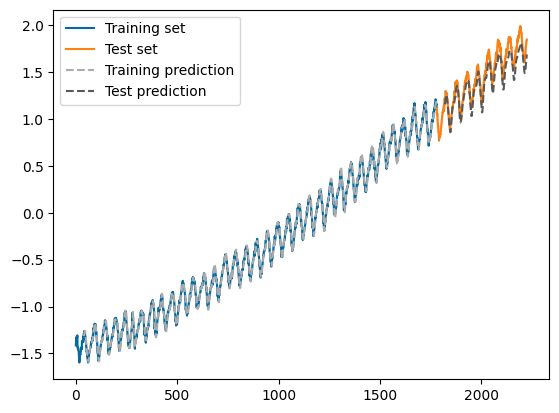

In [43]:
train_pred = model(train_features)[:, -1, :]
test_pred = model(test_features)[:, -1, :]

plt.plot(t, Y, "k", alpha=0.2)
plt.plot(t_train, Y_train, label="Training set")
plt.plot(t_test, Y_test, label="Test set")
plt.plot(t_train[window_size:], train_pred.detach(), "--", label="Training prediction")
plt.plot(t_test[window_size:], test_pred.detach(), "--", label="Test prediction")
plt.legend()
plt.show()

### Prédiction auto-régressive

Une autre façon d'utiliser un modèle comme celui-ci est de manière auto-régressive: on utilise la dernière prédiction du modèle pour faire plus de pas dans le futur.

Voici un petit exemple. Comme on peut voir, le résultat n'est pas excellent. Ce n'est pas trop surprenant: nous n'avons pas explicitement entraîné notre modèle pour accomplir cette tâche. Par contre, certains modèles (ex.: LSTM) performent mieux que d'autres. La taille de la fenêtre utilisée dans l'entraînement aura également un impact.

In [44]:
new_Y = torch.cat([Y_train, torch.empty(200, 1)])
with torch.no_grad():
    for i in range(N_train, len(new_Y)):
        new_pred = model(new_Y[i-window_size:i])
        new_Y[i] = new_pred[..., -1:, :]

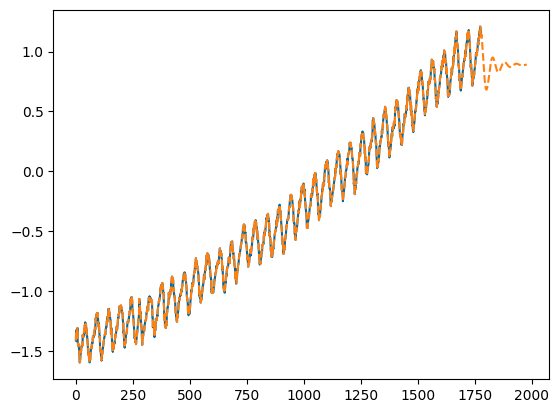

In [45]:
plt.plot(y[:N_train])
plt.plot(new_Y, "--")
plt.show()

## Exercice: Exploration plus avancée

Voici quelques exercices bonus à essayer s'il vous reste du temps. Le tutoriel TensorFlow ci-dessous explore notamment ces questions:

- Comment pourriez-vous modifier le réseau pour prédire plus d'un pas dans le temps?
- Pourriez-vous créer un CNN pour obtenir des résultats similaires?
- Comment pourriez-vous inclure le temps comme entrée dans votre réseau? Ceci permettrait de tenir compte de pas de temps irréguliers!
- Testez un GP sur les données de Mauna Loa et comparez sa prédiction avec celle de votre réseau.

## Références

Voici quelques références intéressantes sur le sujet.

- [LSTM for Time Series Prediction in PyTorch (Machine Learning Mastery)](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/): Tutoriel similaire à la première partie du TP, également en PyTorch. Ce site web a plusieurs tutoriels relativement cours et bien construits si vous voulez explorer certains sujets du cours plus en détail.
- [Tutoriel TensorFlow sur la prédiction météo](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network): plus avancé que ce TP, mais utilise plusieurs idées similaires. Très intéressant si vous souhaitez approfondir les notions couvertes ici!
- [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850): article sur la génération de séquences avec les RNNs